In [1]:
!pwd

/home/giakhang/dev/YOLOF-Mask


In [1]:
import math
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
import albumentations as A 

from detectron2.config import LazyConfig, instantiate
from detectron2.structures import Boxes
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling.meta_arch.dense_detector import permute_to_N_HWA_K
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.transforms import ResizeShortestEdge

from yolof_mask.utils.general import box_iou

In [2]:
config_file = './configs/InstanceSegmentation/yolof_mask_RegNetY_4gf_SAM_3x.py'
cfg = LazyConfig.load(config_file)

batch_size = 4

cfg.dataloader.train.total_batch_size = batch_size
cfg.dataloader.test.batch_size = batch_size

In [3]:
d_name = 'coco2017_train'
annot_phase_path = './datasets/coco2017/coco2017/annotations/instances_val2017.json'
img_phase_dir = './datasets/coco2017/coco2017/val2017'

register_coco_instances(
    d_name, 
    {},
    annot_phase_path,
    img_phase_dir
)

In [4]:
train_loader = instantiate(cfg.dataloader.train)  
train_loader_iter = iter(train_loader)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


filtered out 19504 instances with box_area <= 4000


In [6]:
data = next(train_loader_iter)

In [7]:
MAX_VL = 1e+4

imgs = [x['image'].detach().cpu().permute(1, 2, 0).numpy()[..., ::-1] for x in data]
boxes = [x['instances'].gt_boxes.tensor.cpu().numpy() for x in data]
cls_ids = [x['instances'].gt_classes.numpy() for x in data] 
masks = [x['instances'].gt_masks.tensor.cpu().numpy().astype(np.uint8) for x in data]
sum_masks = [np.zeros(m.shape[1:], dtype=np.uint16) for m in masks]

for i, (mask_img, box_img) in enumerate(zip(masks, boxes)):
    for j in range(mask_img.shape[0]):
        ins_m = mask_img[j].copy()
        box_m = box_img[j].astype(np.int32)

        sum_region = sum_masks[i][box_m[1]:box_m[3], box_m[0]:box_m[2]]
        ins_region = ins_m[box_m[1]:box_m[3], box_m[0]:box_m[2]]
        
        if (sum_region > 0).sum() >= (ins_region > 0).sum():
            sum_region = 0
        else:
            ins_region = 0

        ins_m = ins_m * (j + 1)
        sum_masks[i] += ins_m
        sum_masks[i][sum_masks[i] > (j + 1)] = j + 1
#sum_masks = [np.sum([ism_m * (j + 1) for j, ism_m in enumerate(mask_img)], axis=0) 
             #for i, mask_img in enumerate(masks)]

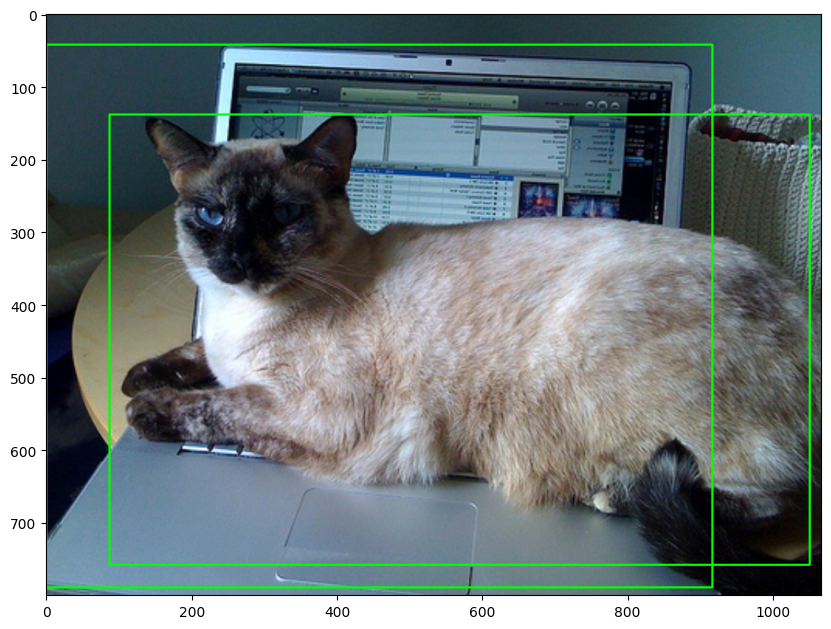

In [8]:
img_id = 0
img = np.ascontiguousarray(imgs[img_id])
boxes_img_i = boxes[img_id]

for box in boxes_img_i:
    box = list(map(int, box))
    cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

_ = plt.figure(figsize=(10, 10))
plt.imshow(img)

In [9]:
transform = A.Compose([
    A.Mosaic(
        grid_yx=(2, 2),
        target_size=(640, 640),
        cell_shape=(400, 400),
        center_range=(0.3, 0.7),
        fit_mode="cover",
        p=1.0
    ),
], bbox_params=A.BboxParams(
    format='pascal_voc', 
    label_fields=['labels'],
    min_area=4000,
    clip=True
))

In [10]:
mosaic_metadata = [
    {
        'image': imgs[1],
        'mask': sum_masks[1],
        'bboxes': boxes[1],
        'labels': cls_ids[1] 
    },
    {
        'image': imgs[2],
        'mask': sum_masks[2],
        'bboxes': boxes[2],
        'labels': cls_ids[2]
    },
    {
        'image': imgs[3],
        'mask': sum_masks[3],
        'bboxes': boxes[3],
        'labels': cls_ids[3]
    }
]

In [11]:
transformed = transform(
    image=imgs[0],
    mask=sum_masks[0],
    bboxes=boxes[0],
    labels=cls_ids[0],
    mosaic_metadata=mosaic_metadata  # Pass the metadata using the default key
)
# Access the transformed data
mosaic_image = transformed['image']        # Combined mosaic image
mosaic_mask = transformed['mask']          # Combined mosaic mask
mosaic_bboxes = transformed['bboxes'].astype(np.int32)      # Combined and repositioned bboxes
mosaic_labels = transformed['labels']      # Combined labels from all images

In [12]:
for box in mosaic_bboxes:
    cv2.rectangle(mosaic_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

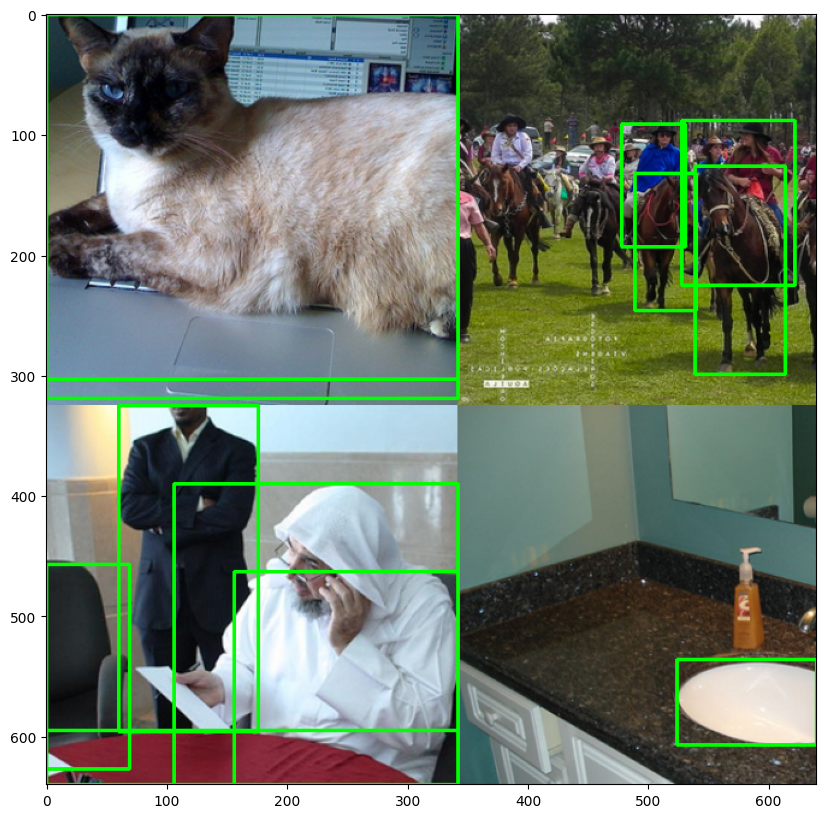

In [13]:
_ = plt.figure(figsize=(10, 10))    
plt.imshow(mosaic_image)

In [14]:
#num_instances = len(mosaic_bboxes)
#masks_size = mosaic_image.shape[:-1]

#ism_mosaic_mask = torch.zeros((num_instances, *masks_size), dtype=torch.bool)

#for i, box in enumerate(mosaic_bboxes):
    #for j in range(1, mosaic_mask.max() + 1):
        #mask_in_box = mosaic_mask[box[1]:box[3], box[0]:box[2]].copy()
        #px_counts = []
        #unique_vls = []
        #for vl in np.unique(mask_in_box):
            #if vl == 0:
                #continue
            #unique_vls.append(vl)
            #px_counts.append(np.sum(mask_in_box == vl))
        #ism_id = unique_vls[np.argmax(px_counts)]
        #mask_in_box[mask_in_box != ism_id] = 0

        #ism_mosaic_mask[i, box[1]:box[3], box[0]:box[2]] = torch.tensor(mask_in_box > 0) 

In [15]:
#ious = torch.zeros((num_instances, mosaic_mask.max()), dtype=torch.float32)

In [16]:
ins, boxes = [], []
num_instances = len(mosaic_bboxes)
masks_size = mosaic_image.shape[:-1]

for i, box in enumerate(mosaic_bboxes):
    for j in range(1, mosaic_mask.max() + 1):
        mask = mosaic_mask.copy()
        mask[mask != j] = 0
        mask[mask == j] = 1
        ins_in_mask = mask[box[1]:box[3], box[0]:box[2]].copy()
        #if (ins_in_mask == 0).sum() >= (ins_in_mask == 1).sum():
            #ins_in_mask = np.zeros(ins_in_mask.shape, dtype=np.uint8)
        ins.append(ins_in_mask)
        y, x = np.where(ins_in_mask > 0)
        if len(x) > 0 and len(y) > 0:
            x_min = x.min()
            x_max = x.max()
            y_min = y.min()
            y_max = y.max()
            boxes.append([x_min, y_min, x_max, y_max])
        else:
            boxes.append([0, 0, 0, 0])

In [17]:
crop_bboxes = np.zeros((len(mosaic_bboxes), 4), dtype=np.float32)
crop_bboxes[:, 0] = mosaic_bboxes[:, 0] - mosaic_bboxes[:, 0]
crop_bboxes[:, 1] = mosaic_bboxes[:, 1] - mosaic_bboxes[:, 1]
crop_bboxes[:, 2] = mosaic_bboxes[:, 2] - mosaic_bboxes[:, 0]
crop_bboxes[:, 3] = mosaic_bboxes[:, 3] - mosaic_bboxes[:, 1]

ious = box_iou(
    torch.tensor(crop_bboxes, dtype=torch.float32), 
    torch.tensor(boxes, dtype=torch.float32)
)

In [18]:
_, iou_args = torch.max(ious, dim=1)

ism_mosaic_mask = torch.zeros((num_instances, *masks_size), dtype=torch.int32)

for i, (box, iou_arg) in enumerate(zip(mosaic_bboxes, iou_args)):
    ism_mosaic_mask[i][box[1]:box[3], box[0]:box[2]] = torch.tensor(ins[iou_arg].astype(np.int32))

RuntimeError: The expanded size of the tensor (69) must match the existing size (75) at non-singleton dimension 1.  Target sizes: [170, 69].  Tensor sizes: [173, 75]

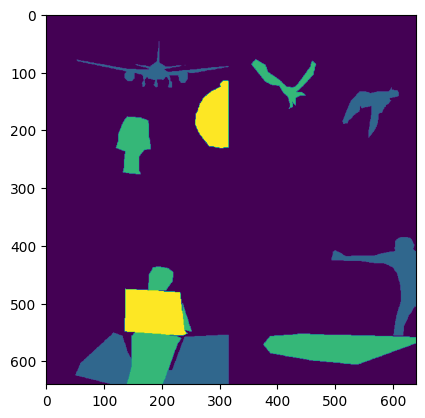

In [ ]:
plt.imshow(mosaic_mask)

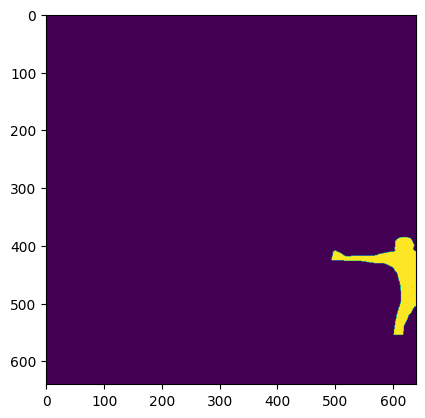

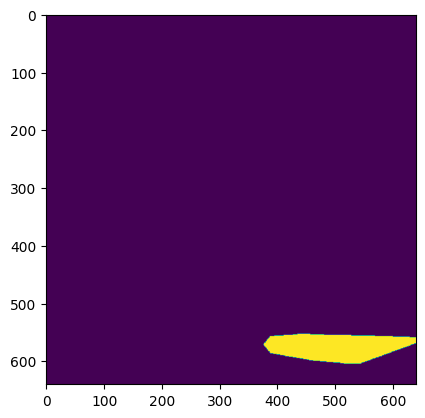

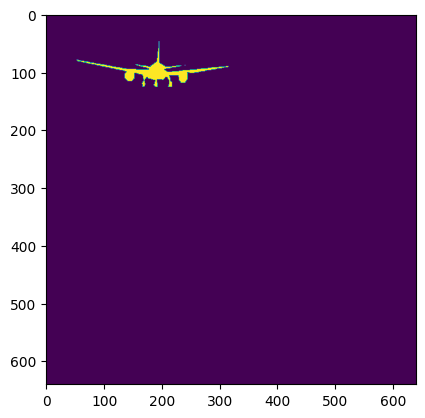

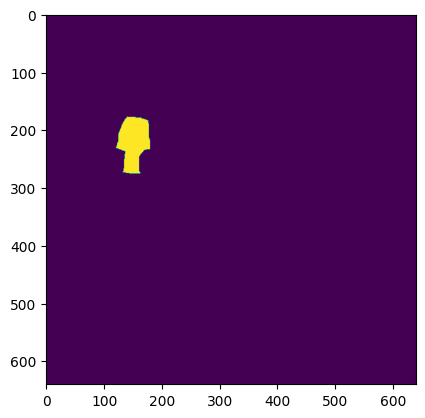

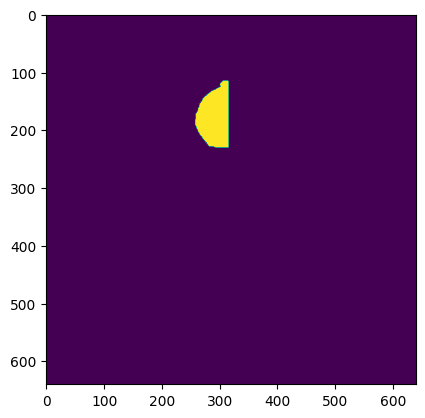

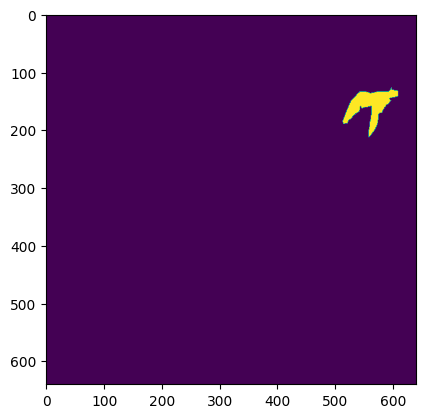

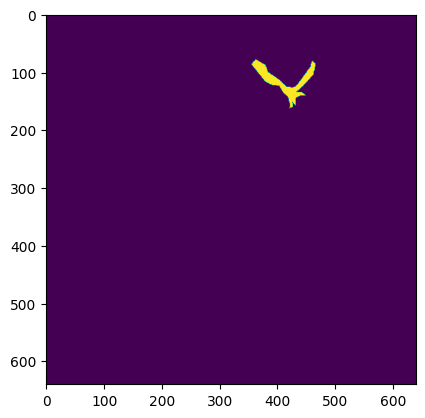

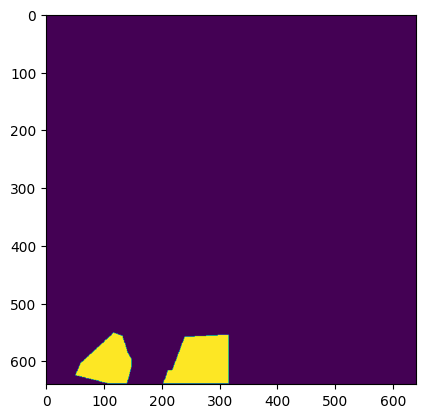

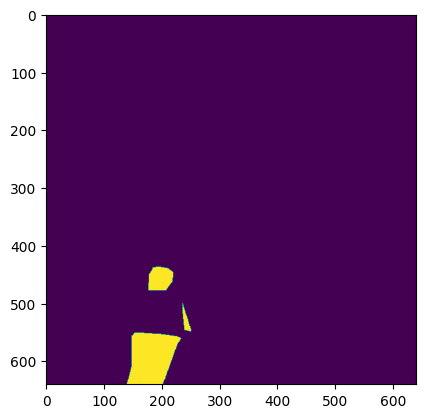

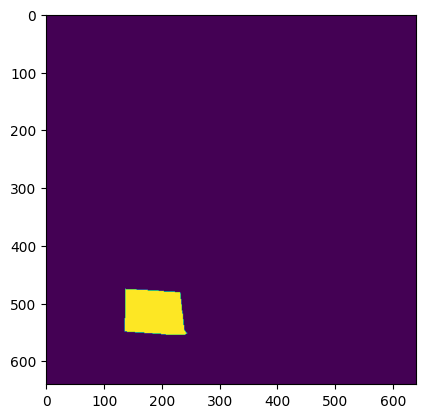

In [ ]:
for i, _ in enumerate(mosaic_bboxes):
    mask = ism_mosaic_mask[i].numpy()
    mask = np.ascontiguousarray(mask)
    plt.imshow(mask)

    plt.show()